[![image.png](https://i.postimg.cc/2jcdcL38/image.png)](https://postimg.cc/3WGDWRgP)

<div style="padding:20px 20px 20px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Предсказание стоимости жилья</p>

</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    

    
__Постановка задачи:__ Используя оценщик LinearRegression из библиотеки MLlib реализовать две модели, построенные на различных наборах данных:
    
- Используя числовые и категориальные данные;
- Используя только числовые данные, исключив категориальные.

__Оценка результата:__ Сравнение качества работы моделей, по метрикам:
    
- RMSE;
- MAE;
- R2.
    
    
__Описание данных:__ Информация о жилье в Калифорнии в 1990 году.

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — Целевой признак: медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [251]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
 
from pyspark.sql.functions import isnan, isnull, count, col, sum, when

import sys

# константы
RANDOM_SEED = 42

In [252]:
# запуск spark-сессии
spark = SparkSession.builder \
                    .master('local') \
                    .appName('spark_home_value_prediction') \
                    .getOrCreate()

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка данных

</div>

In [253]:
# загрузка данных из файла 'housing.csv'
try:
    df = spark.read.csv('housing.csv', header=True, inferSchema=True)
    df.show(2) # вывод первых строк DataFrame
except:
    display('Данные для не доступны')
    raise SystemExit(0)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 2 rows



<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:13px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка и исследовательский анализ данных


</div>

## Общая информация

In [254]:
# подсчет количества строк в DataFrame
display(f'Количество строк в DataFrame: {df.count()}')

'Количество строк в DataFrame: 20640'

In [255]:
# вывод типов данных колонок DataFrame
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [256]:
# общая статистика
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


In [257]:
# преобразование в цельночисленный формат столбцы 'total_rooms', 'total_bedrooms', 'population', 'households'
# для более эффективного использования ресурсов
columns_to_convert = ['total_rooms', 'total_bedrooms', 'population', 'households']

for column in columns_to_convert:
    df = df.withColumn(column, F.col(column).cast('int'))

### Пропуски в данных

In [258]:
# вывод количество пропусков в столбцах
null = [(column,df.filter(F.col(column).isNull()).count()) for column in df.columns]
for column, count in null:
    if count != 0: print(f"Missing items in '{column}': {count}")

Missing items in 'total_bedrooms': 207


<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
Пропуски присутствуют в столбце `total bedrooms` - общее количество спален в домах жилого массива;
    
</div>

#### Обработка пропусков

In [259]:
# корреляция с 'total bedrooms' остальных признаков
corr = {}
for i in numerical_cols:
    corr_ = df.stat.corr('total_bedrooms', i) 
    print(f"Correlation to total_bedrooms for {i}={corr_}")
    corr[i] = corr_total_bedrooms if i != 'total_bedrooms' else 0
    
print(f"\nMaximum correlation to '{max(corr, key=corr.get)}'")

Correlation to total_bedrooms for median_income=-0.0072945417081858544
Correlation to total_bedrooms for households=0.966507240042043
Correlation to total_bedrooms for population=0.8662661985860806
Correlation to total_bedrooms for total_bedrooms=1.0
Correlation to total_bedrooms for total_rooms=0.9201961721166215
Correlation to total_bedrooms for housing_median_age=-0.31706334936263136
Correlation to total_bedrooms for longitude=0.06808179725677305
Correlation to total_bedrooms for latitude=-0.06531831669569808

Maximum correlation to 'total_bedrooms'


<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
Наибольшей линейной связью `total bedrooms` обладает с `households` - количество домовладений в жилом массиве.
    
</div>

In [260]:
# расчет количества спален на домовладение
df = df.withColumn('bedrooms_per_household', F.col('total_bedrooms')/F.col('households'))

In [261]:
# среднее количество спален на дом
mean_value = round(df.select(F.mean('bedrooms_per_household')).first()[0])
print(f'Среднее количество спален на дом: {mean_value}')

Среднее количество спален на дом: 1


<div style="padding: 30px 25px; border: 2px #6495ed solid">
Средне количество спален на домовладение равно 1, соответственно количество спален будет равно количеству домовладений в жилом массиве.
    </div>

In [262]:
# заполнение пропусков в столбце 'total_bedrooms' значениями из households
df = df.withColumn('total_bedrooms', when(df['total_bedrooms'].isNull(), df['households']*mean_value).otherwise(df['total_bedrooms']))

In [263]:
# удаление вспомогательного столбца 'bedrooms_per_household'
df = df.drop(F.col('bedrooms_per_household'))

In [264]:
# вывод количества пропусков в столбцах для проверки заполнения пропусков
null = [(column,df.filter(F.col(column).isNull()).count()) for column in df.columns]
for column, count in null:
    display(f'{column}: {count}')

'longitude: 0'

'latitude: 0'

'housing_median_age: 0'

'total_rooms: 0'

'total_bedrooms: 0'

'population: 0'

'households: 0'

'median_income: 0'

'median_house_value: 0'

'ocean_proximity: 0'

<div style="padding: 30px 25px; border: 2px #6495ed solid">
Пропуски заполнили
    </div>

### Кореляция с целевым признаком

In [265]:
# корреляция целевого с остальными признаками
corr = {}
for i in numerical_cols:
    corr_ = df.stat.corr(target, i)
    print(f'Correlation to {target} for {i}={corr_}')
    corr[i] = corr_ if i != target else 0
print(f'\nMaximum correlation to "{max(corr, key=corr.get)}"')

Correlation to median_house_value for median_income=0.6880752079585578
Correlation to median_house_value for households=0.06584265057005637
Correlation to median_house_value for population=-0.024649678888894876
Correlation to median_house_value for total_bedrooms=0.050688452962582564
Correlation to median_house_value for total_rooms=0.13415311380656275
Correlation to median_house_value for housing_median_age=0.10562341249321067
Correlation to median_house_value for longitude=-0.045966615117981745
Correlation to median_house_value for latitude=-0.14416027687465752

Maximum correlation to "median_income"


<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
Наиболишая линейная зависимость стоимости жилья наблюдается с `median income` - медианный доход жителей жилого массива

</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Подготовка данных к построению модели
    
</div>

In [266]:
# выделение числовые, текстовые и целевой признаки
categorical_cols = ['ocean_proximity']

numerical_cols  = ['median_income', 'households', 'population', 'total_bedrooms', 'total_rooms',
                  'housing_median_age', 'longitude', 'latitude']

# переименование целевого признака в 'label' 
df = df.withColumnRenamed('median_house_value', 'label') 

### Разделение на выборки
Разделим датасет в следующих пропорциях:
- train_data 80%
- test_data 20%

In [267]:
train_data, test_data = df.randomSplit([.8,.2], seed=RANDOM_SEED)

print(f'{train_data.count()/df.count():.0%} Training set\n{test_data.count()/df.count():.0%} Test set') 

80% Training set
20% Test set


### Pipeline для подготовки признаков

In [268]:
# Pipeline для категориальных и числовых признаков
stages = []
# трансформация категориальных признаков
# трансформер StringIndexer
stages.append(StringIndexer(
        inputCols=categorical_cols,
        outputCols=[c+'_idx' for c in categorical_cols],
        handleInvalid = 'keep')
             )
# OHE-кодирование
stages.append(OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])
             )       
# объединение категориальных признаков в один вектор
stages.append(VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                        outputCol='categorical_features')
             )

# трансформация числовых признаков
# шкалирование значений 
stages.append(VectorAssembler(inputCols=numerical_cols,
                        outputCol='numerical_features')
             )
#StandardScaler
stages.append(StandardScaler(inputCol='numerical_features',
                        outputCol='numerical_features_scaled')
             )
# объединение признаков в один вектор
all_features = ['categorical_features','numerical_features_scaled']
stages.append(VectorAssembler(inputCols=all_features, 
                        outputCol='features')
             )
# модель
stages.append(LinearRegression(labelCol='label', featuresCol='features')
             )
# задаем план stages для обучения модели 
pipeline = Pipeline(stages=stages)

In [269]:
# Pipeline для числовых признаков
stages_num = []
# трансформация числовых признаков
# шкалирование значений 
stages_num.append(VectorAssembler(inputCols=numerical_cols,
                                outputCol='numerical_features')
                 )
#StandardScaler
stages_num.append(StandardScaler(inputCol='numerical_features',
                                outputCol='numerical_features_scaled')
                 )

# модель
stages_num.append(LinearRegression(labelCol='label', featuresCol='numerical_features_scaled')
                 )
# задаем план stages_num для обучения модели 
pipeline_num = Pipeline(stages=stages_num)

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Обучение моделей
    
</div>

При построении моделей используем подбор по сетке гиперпараметров с кросс-валидацией

In [270]:
# сетка гиперпараметров
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.5, 1.0]) \
    .build()

# функция кросс-валидации
def CrosVal(pipeline):
    cv = CrossValidator(estimator=pipeline,
                estimatorParamMaps=paramGrid,
                evaluator=RegressionEvaluator(metricName='rmse'),
                numFolds=4)
    return cv

### Обучение LinearRegression на всех данных

In [ ]:
# обучение модели
cv_model_all = CrosVal(pipeline).fit(train_data)

In [272]:
# предсказание модели
predictions_all = cv_model_all.transform(test_data)
predictedLabes_all = predictions_all.select('label', 'prediction')
predictedLabes_all.show(3) 

+--------+------------------+
|   label|        prediction|
+--------+------------------+
|103600.0|150586.90814287588|
|106700.0| 216824.9374863496|
| 73200.0|126130.22753361426|
+--------+------------------+
only showing top 3 rows



### Обучение LinearRegression на числовых данных

In [ ]:
# обучаем модель
cv_model_num = CrosVal(pipeline_num).fit(train_data)

In [274]:
# предсказание модели
predictions_num = cv_model_num.transform(test_data)
predictedLabes_num = predictions_num.select('label', 'prediction')
predictedLabes_num.show(3) 

+--------+------------------+
|   label|        prediction|
+--------+------------------+
|103600.0|101389.51858995808|
|106700.0|190033.05866057798|
| 73200.0| 76417.54363664845|
+--------+------------------+
only showing top 3 rows



### Метрики качества моделей

Сравним результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2

In [278]:
# функция расчета метрик
def metrics(predicted):
    evaluator_rmse = RegressionEvaluator(predictionCol="prediction", labelCol='label', metricName="rmse")
    evaluator_mae = RegressionEvaluator(predictionCol="prediction", labelCol='label', metricName="mae")
    evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol='label', metricName="r2")
    
    rmse = evaluator_rmse.evaluate(predicted)
    mae = evaluator_mae.evaluate(predicted)
    r2 = evaluator_r2.evaluate(predicted)
    return rmse, mae, r2

In [279]:
# метрики медели, обученной на всех признаках
rmse_all, mae_all, r2_all = metrics(predictedLabes_all)

In [280]:
# метрики медели, обученной на числовых признаках
rmse_num, mae_num, r2_num = metrics(predictedLabes_num)

#### Сравнение метрик качества моделей

,Метрики,LR по всем данным,LR по числовым данным,Comparison
0,RMSE,70604.940121,71567.036768,0.013443
1,MAE,50778.108229,51675.146316,0.017666
2,R2,0.639700,0.629814,0.015454


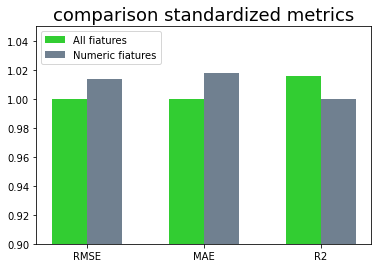

In [352]:
# сводная таблица метрик
df_info = pd.DataFrame({
    'Метрики':['RMSE', 'MAE', 'R2'],
    'LR по всем данным':[rmse_all, mae_all, r2_all],
    'LR по числовым данным':[rmse_num, mae_num, r2_num],
    'Comparison':[(rmse_num-rmse_all)/rmse_num, (mae_num-mae_all)/mae_all, (r2_all-r2_num)/r2_all]
    })
display(df_info)

# визуализация
index = np.arange(len(df_info))
values1 = [rmse_all/rmse_all, mae_all/mae_all, r2_all/r2_num]
values2 = [rmse_num/rmse_all, mae_num/mae_all, r2_num/r2_num]
bw = 0.3
plt.title('comparison standardized metrics', fontsize=18)
plt.bar(index, values1, bw, color='limegreen')
plt.bar(index+bw, values2, bw, color='slategrey')
plt.ylim([0.9, 1.05])
plt.legend(['All fiatures', 'Numeric fiatures'], loc=2)
plt.xticks(index+bw/2, df_info['Метрики'])
plt.show()

In [283]:
# закрытие spark-сессии
spark.stop()

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Вывод
    
</div>

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
- Для предобработки данных был применен алгоритм, реализованный в рамках фреймворка Spark.
- Для создания двух моделей был использован оценщик LinearRegression из библиотеки MLlib, и каждая модель была построена на отдельном наборе данных.
- Было проведено сравнение метрик качества моделей для определения их относительной эффективности.    
- Использование как числовых, так и категориальных признаков в модели приводит к улучшению ее качества по всем использованным метрикам качества, в сравнении с моделью, обученной только на числовых данных.
- Полученные значения итоговых метрик являются очень низкими. Для улучшения этих метрик стоит рассмотреть возможность применения других алгоритмов обучения.
</div>